In [0]:
!pip install mlflow
!pip install prophet

     |████▎                           | 3.6 MB 4.7 MB/s eta 0:00:05

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 14.4 MB 4.8 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 48.4 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-8226d86d-2985-403a-b877-5227efd75f62/bin/python -m pip install --upgrade pip' command.


In [0]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Sales Forecasting with Prophet") \
    .getOrCreate()


In [0]:
data_path = "/FileStore/shared_uploads/podurikarthikeya69@gmail.com/PROPHETT.csv"  # Corrected path without /dbfs/
df_spark = spark.read.csv(data_path, header=True, inferSchema=True)
df_spark.show()

+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+-----+-----------+---------------------+-------------------------+
|    HostItemID|  Cost|  List|OnHand|MonthsNoSale|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|MonthsWithAtLeastOneSale|Year|    Month|Sales|Lag_1|HolidayFlag|InventoryDiff_Reorder|InventoryDiff_SafetyStock|
+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+-----+-----------+---------------------+-------------------------+
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021|  January|   39|  NaN|          0|                  110|                       70|
|PMP*14680*2541| 385.0|873.72|   184|          17|  2021

In [0]:
df = df_spark.toPandas()
df.head()

,HostItemID,Cost,List,OnHand,MonthsNoSale,LastSaleDate,PriorYearSales,OnOrderQty,BestReorderPoint,SafetyStockLevel,MonthsWithAtLeastOneSale,Year,Month,Sales,Lag_1,HolidayFlag,InventoryDiff_Reorder,InventoryDiff_SafetyStock
0,PMP*14680*2541,381.96,873.72,184,17,2021-04-17,217,62,74,39,8,2021,January,39,NaN,0,110,70
1,PMP*14680*2541,385.00,873.72,184,17,2021-04-17,217,62,74,39,8,2021,February,39,39.0,0,90,50
2,PMP*14680*2541,390.50,873.72,184,17,2021-04-17,217,62,74,39,8,2021,March,22,39.0,0,60,40
3,PMP*14680*2541,395.75,873.72,184,17,2021-04-17,217,62,74,39,8,2021,April,34,22.0,0,50,30
4,PMP*14680*2541,400.00,873.72,184,17,2021-04-17,217,62,74,39,8,2021,May,0,34.0,1,40,20


In [0]:
df.rename(columns={'LastSaleDate': 'ds', 'Sales': 'y'}, inplace=True)
df.head()

,HostItemID,Cost,List,OnHand,MonthsNoSale,ds,PriorYearSales,OnOrderQty,BestReorderPoint,SafetyStockLevel,MonthsWithAtLeastOneSale,Year,Month,y,Lag_1,HolidayFlag,InventoryDiff_Reorder,InventoryDiff_SafetyStock
0,PMP*14680*2541,381.96,873.72,184,17,2021-04-17,217,62,74,39,8,2021,January,39,NaN,0,110,70
1,PMP*14680*2541,385.00,873.72,184,17,2021-04-17,217,62,74,39,8,2021,February,39,39.0,0,90,50
2,PMP*14680*2541,390.50,873.72,184,17,2021-04-17,217,62,74,39,8,2021,March,22,39.0,0,60,40
3,PMP*14680*2541,395.75,873.72,184,17,2021-04-17,217,62,74,39,8,2021,April,34,22.0,0,50,30
4,PMP*14680*2541,400.00,873.72,184,17,2021-04-17,217,62,74,39,8,2021,May,0,34.0,1,40,20


In [0]:
df['ds'] = pd.to_datetime(df['ds'])
print(df.isnull().sum())
df = df.dropna()
df = df.sort_values('ds')
df.head()

HostItemID                   0
Cost                         0
List                         0
OnHand                       0
MonthsNoSale                 0
ds                           0
PriorYearSales               0
OnOrderQty                   0
BestReorderPoint             0
SafetyStockLevel             0
MonthsWithAtLeastOneSale     0
Year                         0
Month                        0
y                            0
Lag_1                        1
HolidayFlag                  0
InventoryDiff_Reorder        0
InventoryDiff_SafetyStock    0
dtype: int64


,HostItemID,Cost,List,OnHand,MonthsNoSale,ds,PriorYearSales,OnOrderQty,BestReorderPoint,SafetyStockLevel,MonthsWithAtLeastOneSale,Year,Month,y,Lag_1,HolidayFlag,InventoryDiff_Reorder,InventoryDiff_SafetyStock
1,PMP*14680*2541,385.00,873.72,184,17,2021-04-17,217,62,74,39,8,2021,February,39,39.0,0,90,50
2,PMP*14680*2541,390.50,873.72,184,17,2021-04-17,217,62,74,39,8,2021,March,22,39.0,0,60,40
3,PMP*14680*2541,395.75,873.72,184,17,2021-04-17,217,62,74,39,8,2021,April,34,22.0,0,50,30
4,PMP*14680*2541,400.00,873.72,184,17,2021-04-17,217,62,74,39,8,2021,May,0,34.0,1,40,20
5,PMP*14680*2541,405.25,873.72,184,17,2021-04-17,217,62,74,39,8,2021,June,27,0.0,0,30,15


In [0]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]
print(f"Training set size: {len(train)}")
print(f"Testing set size: {len(test)}")

Training set size: 21
Testing set size: 6


In [0]:
model = Prophet()
model.fit(df[['ds', 'y']])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqp1opjn/3plf15i7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyqp1opjn/83b8hput.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/local_disk0/.ephemeral_nfs/envs/pythonEnv-8226d86d-2985-403a-b877-5227efd75f62/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50189', 'data', 'file=/tmp/tmpyqp1opjn/3plf15i7.json', 'init=/tmp/tmpyqp1opjn/83b8hput.json', 'output', 'file=/tmp/tmpyqp1opjn/prophet_model321ro4je/prophet_model-20241007163924.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:39:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start proc

Out[18]: <prophet.forecaster.Prophet at 0x7f79f709cf10>

In [0]:
print(future)

          ds
0 2021-04-17
1 2022-04-17
2 2023-04-17
3 2023-04-30
4 2023-05-31
5 2023-06-30
6 2023-07-31
7 2023-08-31
8 2023-09-30


In [0]:
print(test['ds'])


21   2023-04-17
22   2023-04-17
23   2023-04-17
24   2023-04-17
25   2023-04-17
27   2023-04-17
Name: ds, dtype: datetime64[ns]


In [0]:
test = test.drop_duplicates(subset='ds').reset_index(drop=True)
print(test)

       HostItemID    Cost    List  OnHand  MonthsNoSale         ds  \
0  PMP*14680*2541  490.25  873.72     184            17 2023-04-17   

   PriorYearSales  OnOrderQty  BestReorderPoint  SafetyStockLevel  \
0             223          62                74                39   

   MonthsWithAtLeastOneSale  Year     Month   y  Lag_1  HolidayFlag  \
0                         8  2023  February  45   50.0            0   

   InventoryDiff_Reorder  InventoryDiff_SafetyStock  
0                     90                         50  


In [0]:
future = model.make_future_dataframe(periods=len(test), freq='M')
forecast = model.predict(future)
forecast_test = forecast[forecast['ds'].isin(test['ds'])]
print(f"Length of actual sales (test): {len(test)}")
print(f"Length of forecasted sales: {len(forecast_test)}")
if len(forecast_test) != len(test):
    print("Lengths do not match! Check the dates.")
else:
    rmse = mean_squared_error(test['y'], forecast_test['yhat'])
    mae = mean_absolute_error(test['y'], forecast_test['yhat'])
    print(f"RMSE: {rmse}, MAE: {mae}")

Length of actual sales (test): 1
Length of forecasted sales: 1
RMSE: 244.21635952300824, MAE: 15.627423316817403


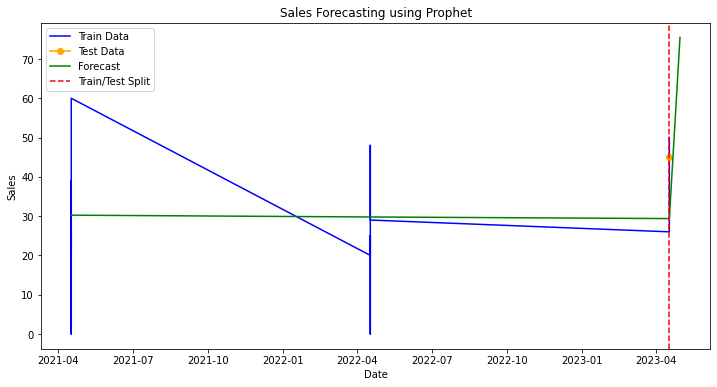

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Train Data', color='blue')
plt.plot(test['ds'], test['y'], label='Test Data', color='orange', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='green')
plt.axvline(x=train['ds'].iloc[-1], color='red', linestyle='--', label='Train/Test Split')

plt.title('Sales Forecasting using Prophet')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [0]:
import joblib
joblib.dump(model, 'prophet_sales_forecast.pkl')

Out[29]: ['prophet_sales_forecast.pkl']

In [0]:
import mlflow
import mlflow.prophet
with mlflow.start_run():
    mlflow.log_param("model_type", "Prophet")
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    mlflow.prophet.log_model(model, "prophet_model")

    mlflow.log_artifact('prophet_sales_forecast.pkl')
    
    print("Model and metrics logged to MLflow.")

2024/10/07 16:44:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

2024/10/07 16:44:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run luminous-trout-601 at: https://community.cloud.databricks.com/ml/experiments/4498943658609911/runs/3f5109f4c37248c2863171eef1b338a8.
2024/10/07 16:44:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/4498943658609911.


Model and metrics logged to MLflow.
